<a href="https://colab.research.google.com/github/marlo37/Tensorflow/blob/main/4_Introduction_to_gradients_and_automatic_differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction to gradients and automatic differentiation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/autodiff"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Automatic Differentiation and Gradients

[Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)
is useful for implementing machine learning algorithms such as
[backpropagation](https://en.wikipedia.org/wiki/Backpropagation) for training
neural networks.

In this guide, you will explore ways to compute gradients with TensorFlow, especially in eager execution.

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## Computing gradients

To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the *forward* pass.  Then, during the *backward pass*, TensorFlow traverses this list of operations in reverse order to compute gradients.

자동으로 미분하기 위해 TensorFlow는 정방향 패스 중에 어떤 Ops이 어떤 순서로 발생하는지 기억해야 합니다. 그런 다음 역방향 패스 중에 TensorFlow는 이 Ops 목록을 역순으로 탐색하여 기울기를 계산합니다.

## Gradient tapes

TensorFlow provides the `tf.GradientTape` API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variable`s.
TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using [reverse mode differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

Here is a simple example:

TensorFlow는 자동 미분을 위해 tf.GradientTape API를 제공합니다. 즉, 일반적으로 tf.Variables와 같은 일부 입력에 대한 계산의 gradients를 계산합니다. TensorFlow는 tf.GradientTape 컨텍스트 내에서 실행된 관련 Ops을 "테이프"에 "기록"합니다. 그런 다음 TensorFlow는 해당 테이프를 사용하여 `reverse 모드 미분`을 사용하여 "기록된" 계산의 gradients를 계산합니다.

다음은 간단한 예입니다.

In [ ]:
xx = 4
yy = xx**3
print(yy)

64


In [ ]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape: # current persistent[default:false]
  y = x**2  # y' = 2x

Once you've recorded some operations, use `GradientTape.gradient(target, sources)` to calculate the gradient of some target (often a loss) relative to some source (often the model's variables):

일부 Ops을 기록했으면 `GradientTape.gradient(target, sources)`를 사용하여 일부 소스(종종 모델의 변수)에 대한 일부 타겟(종종 loss)의 기울기를 계산합니다.

In [ ]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


In [ ]:
dy_dx = tape.gradient(y, x)

RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

The above example uses scalars, but `tf.GradientTape` works as easily on any tensor:

위의 예는 스칼라(소스가 스칼라)를 사용하지만 tf.GradientTape는 모든 텐서에서 쉽게 작동합니다.

In [ ]:
meanx = tf.constant([[1., 1.], [2., 2.]])
tf.reduce_mean(meanx)

<tf.Tensor: shape=(), dtype=float32, numpy=1.5>

In [ ]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape: #persistent[default:False]
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

To get the gradient of `loss` with respect to both variables, you can pass both as sources to the `gradient` method. The tape is flexible about how sources are passed and will accept any nested combination of lists or dictionaries and return the gradient structured the same way (see `tf.nest`).

두 변수에 대한 손실 기울기를 얻으려면 둘 다 `gradient` 메소드에 소스로 전달할 수 있습니다. 테이프는 소스가 전달되는 방식에 대해 유연하며 `list` 또는 `dictionary`의 중첩된 조합을 허용하고 동일한 방식으로 구조화된 그래디언트를 반환합니다(tf.nest 참조).

In [ ]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])
print(dl_dw)
print(dl_db)

tf.Tensor(
[[-0.95340586 -1.4424624 ]
 [-1.9068117  -2.884925  ]
 [-2.8602176  -4.3273873 ]], shape=(3, 2), dtype=float32)
tf.Tensor([-0.95340586 -1.4424624 ], shape=(2,), dtype=float32)


In [ ]:
print(dl_db)

tf.Tensor([-0.95340586 -1.4424624 ], shape=(2,), dtype=float32)


The gradient with respect to each source has the shape of the source:

각 소스에 대한 gradient는 소스의 shape을 갖습니다.

In [ ]:
print(w.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


Here is the gradient calculation again, this time passing a dictionary of variables:

다음은 다시 gradient 계산입니다. 이번에는 dictionary 타입의 변수를 전달합니다.

In [ ]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
print(grad['w'])
print(grad['b'])

tf.Tensor(
[[-0.95340586 -1.4424624 ]
 [-1.9068117  -2.884925  ]
 [-2.8602176  -4.3273873 ]], shape=(3, 2), dtype=float32)
tf.Tensor([-0.95340586 -1.4424624 ], shape=(2,), dtype=float32)


In [ ]:
del tape

## Gradients with respect to a model

It's common to collect `tf.Variables` into a `tf.Module` or one of its subclasses (`layers.Layer`, `keras.Model`) for [checkpointing](checkpoint.ipynb) and [exporting](saved_model.ipynb).

In most cases, you will want to calculate gradients with respect to a model's trainable variables.  Since all subclasses of `tf.Module` aggregate their variables in the `Module.trainable_variables` property, you can calculate these gradients in a few lines of code:

checkpointing 및 exporting를 위해 tf.Variables를 tf.Module 또는 tf.Module 하위 클래스(layers.Layer, keras.Model) 중 하나로 collect하는 것이 일반적입니다.

대부분의 경우 모델의 학습 가능한 변수에 대한 gradient를 계산하려고 합니다. **tf.Module의 모든 하위 클래스는 Module.trainable_variables 속성에서 변수를 집계(aggregate)**하므로 몇 줄의 코드로 이러한 gradient를 계산할 수 있습니다.

In [ ]:
layer = tf.keras.layers.Dense(2, activation='relu') # Dense는 keras에서 지원해주는 hidden layer[Full connected layer]
# 현재, layer의 weight 파라미터의 갯수를 알 수 있는가?
# 그러나 bias의 갯수는 알 수 있다

x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  # layer.trainable = False
  # 이제 layer의 weight 파라미터 갯수를 알 수 있다.
  # print("y=", y)
  loss = tf.reduce_mean(y**2)

In [ ]:
print(layer.trainable_variables)

[<tf.Variable 'dense/kernel:0' shape=(3, 2) dtype=float32, numpy=
array([[-0.34844542, -0.826694  ],
       [ 0.7003    , -0.48246288],
       [-0.86702716, -0.90831   ]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]


In [ ]:
# layer.trainable = False # Gradient Tape context 외부에서 설정을 해도 적용이 된다

In [ ]:
# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)
print(grad)

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>]


zip() 기본 문법

zip() 함수는 여러 개의 순회 가능한(iterable) 객체를 인자로 받고, 각 객체가 담고 있는 원소를 tuple의 형태로 차례로 접근할 수 있는 반복자(iterator)를 반환

In [ ]:
numbers = [1, 2, 3]
letters = ["A", "B", "C"]
for pair in zip(numbers, letters):
  print(pair)

(1, 'A')
(2, 'B')
(3, 'C')


In [ ]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


<a id="watches"></a>

## Controlling what the tape watches

The default behavior is to record all operations after accessing a trainable `tf.Variable`. The reasons for this are:

* The tape needs to know which operations to record in the forward pass to calculate the gradients in the backwards pass.
* The tape holds references to intermediate outputs, so you don't want to record unnecessary operations.
* The most common use case involves calculating the gradient of a loss with respect to all a model's trainable variables.

For example, the following fails to calculate a gradient because the `tf.Tensor` is not "watched" by default, and the `tf.Variable` is not trainable:

기본 동작은 **trainable** tf.Variable에 액세스한 후 모든 Ops을 기록하는 것입니다. 그 이유는 다음과 같습니다.
* 테이프는 역방향 패스의 기울기를 계산하기 위해 순방향 패스에 기록할 오퍼레이션들을 알아야 합니다.
* 테이프에는 중간 출력에 대한 참조가 있으므로 불필요한 오퍼레이션들을 기록하고 싶지 않습니다.
* 가장 일반적인 사용 사례는 모델의 모든 학습 가능한 변수에 대한 loss의 기울기를 계산하는 것입니다.

예를 들어, 다음 코드은 `tf.Tensor`가 기본적으로 "감시"가 되지 않고 `tf.Variable`의 `trainable` 속성이 `False`이기 때문에 그라디언트를 계산하는 데 실패합니다.

In [ ]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')

# Not trainable
# tf.Variable의 trainable 속성이 False이기 때문에 그라디언트를 계산하는 데 실패합니다.
x1 = tf.Variable(3.0, name='x1', trainable=False)

# Not a Variable: A variable + tensor returns a tensor.
# x2 = tf.Variable(2.0, name='x2') + 1.0
x2 = tf.Variable(2.0, name='x2')
# print("x2=", x2)

# Not a variable
x3 = tf.constant(3.0, name='x3')

In [ ]:
with tf.GradientTape() as tape:
  # tape.watch(x2) # GradientTape의 watched_variables 속성에 반영되지 않는다
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print("g=", g)

g= tf.Tensor(6.0, shape=(), dtype=float32)
g= None
g= tf.Tensor(4.0, shape=(), dtype=float32)
g= None


You can list the variables being watched by the tape using the `GradientTape.watched_variables` method:

GradientTape.watched_variables 메서드를 사용하여 테이프에서 감시 중인 변수를 나열할 수 있습니다.

In [ ]:
for var in tape.watched_variables():
  print(var.name)

x0:0
x2:0


In [ ]:
[var.name for var in tape.watched_variables()]

['x0:0', 'x2:0']

`tf.GradientTape` provides hooks that give the user control over what is or is not watched.

To record gradients with respect to a `tf.Tensor`, you need to call `GradientTape.watch(x)`:

tf.GradientTape는 사용자가 감시 여부를 제어할 수 있는 hook를 제공합니다.</br>
tf.Tensor에 대한 그라디언트를 기록하려면 GradientTape.watch(x)를 호출해야 합니다.

In [ ]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


In [ ]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx)

None


Conversely, to disable the default behavior of watching all `tf.Variables`, set `watch_accessed_variables=False` when creating the gradient tape. This calculation uses two variables, but only connects the gradient for one of the variables:

<font color="red">반대로 감시하고 있는 모든 tf.Variables 디폴트 동작을 비활성화하려면</font> 그래디언트 테이프를 생성할 때 **watch_accessed_variables=False**로 설정하십시오. 이 계산은 두 개의 변수를 사용하지만 변수 중 하나에 대한 gradient만 연결합니다.

In [ ]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

Since `GradientTape.watch` was not called on `x0`, no gradient is computed with respect to it:

'x0'에 대해 'GradientTape.watch'가 호출되지 않았으므로 이와 관련된 그라디언트가 계산되지 않습니다.

In [ ]:
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'])
# print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: tf.Tensor(0.9999546, shape=(), dtype=float32)


## Intermediate results

You can also request gradients of the output with respect to intermediate values computed inside the `tf.GradientTape` context.

또한 tf.GradientTape 컨텍스트 내에서 계산된 중간 값에 대한 출력 기울기를 요청할 수 있습니다.

In [ ]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x  # y is intermediate value
  z = y * y #y**2 -> 2y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


By default, the resources held by a `GradientTape` are released as soon as the `GradientTape.gradient` method is called. To compute multiple gradients over the same computation, create a gradient tape with `persistent=True`. This allows multiple calls to the `gradient` method as resources are released when the tape object is garbage collected. For example:

기본적으로 GradientTape.gradient 메서드가 호출되는 즉시 GradientTape가 보유한 리소스가 해제됩니다. 동일한 계산에 대해 복수의 그라디언트를 계산하려면 Persistent=True인 그라디언트 테이프를 만듭니다. 이렇게 하면 테이프 개체가 garbage collection이 수행될 때 테이프 개체 리소스가 해제되므로 tape.gradient 메서드를 여러 번 호출할 수 있습니다. 예를 들어:

In [ ]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])

[  4. 108.]
[2. 6.]


In [ ]:
del tape   # Drop the reference to the tape

## Notes on performance

* There is a tiny overhead associated with doing operations inside a gradient tape context. For most eager execution this will not be a noticeable cost, but you should still use tape context around the areas only where it is required.

* Gradient tapes use memory to store intermediate results, including inputs and outputs, for use during the backwards pass.

  For efficiency, some ops (like `ReLU`) don't need to keep their intermediate results and they are pruned during the forward pass. However, if you use `persistent=True` on your tape, *nothing is discarded* and your peak memory usage will be higher.

* 그래디언트 테이프 컨텍스트 내에서 Ops을 수행하는 것과 관련된 약간의 오버헤드가 있습니다. 대부분의 eager 실행 모드의 경우, 이는 눈에 띄는 비용은 아니지만 필요한 영역에서만 테이프 컨텍스트를 사용해야 합니다.

* 그라디언트 테이프는 backward pass 동안 사용할 입력 및 출력을 포함한 중간 결과를 저장하기 위해 메모리를 사용합니다.</br>
효율성을 위해 일부 Ops(예: ReLU)은 중간 결과를 유지할 필요가 없으며 forward pass 중에 정리됩니다. 그러나 테이프에서 Persistent=True를 사용하면 어떤 것도 버리지 않기 때문에 메모리 최대 사용량이 더 높아집니다.

## Gradients of non-scalar targets

A gradient is fundamentally an operation on a scalar.

gradient는 기본적으로 스칼라에 대한 Ops입니다.

y = 1/x</br>
y = x<sup>-1</sup></br>
y = -1x<sup>-2</sup></br>
y = -1/x<sup>2</sup></br>

#### y1 = 1 / x
* y1 = x<sup>-1</sup>
* y1' = -1x<sup>-2</sup>

In [ ]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


Thus, if you ask for the gradient of multiple targets, the result for each source is:

* The gradient of the sum of the targets, or equivalently
* The sum of the gradients of each target.

따라서 여러 타겟의 gradient를 요청하면 각 소스에 대한 결과는 다음과 같습니다.

* target 합계의 gradient, 또는 동등하게
* 각 target의 gradient의 합계입니다.

 아래 코드에서 non-scalar targets 은 </br>
 {'y0': y0, 'y1': y1}를 의미한다.

In [ ]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


Similarly, if the target(s) are not scalar the gradient of the sum is calculated:

마찬가지로, 타겟이 스칼라가 아닌 경우 합계의 기울기가 계산됩니다.

In [ ]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.] # [3., 4.]x , y' = [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


This makes it simple to take the gradient of the sum of a collection of losses, or the gradient of the sum of an element-wise loss calculation.

If you need a separate gradient for each item, refer to [Jacobians](advanced_autodiff.ipynb#jacobians).

이것은 손실 모음 합계의 기울기 또는 요소별 손실 계산 합계 기울기를 취하는 것을 간단하게 만듭니다.

각 항목에 대해 별도의 그래디언트가 필요한 경우 Jacobians를 참조하십시오.

In some cases you can skip the Jacobian. For an element-wise calculation, the gradient of the sum gives the derivative of each element with respect to its input-element, since each element is independent:

경우에 따라 야코비 행렬을 건너뛸 수 있습니다. element-wise 계산의 경우에 합계의 기울기는 각 element가 독립적이므로 입력 요소에 대한 각 element의 도함수를 제공합니다.

In [ ]:
x = tf.linspace(-10.0, 10.0, 200+1)
print(x)

tf.Tensor(
[-10.          -9.9         -9.8         -9.7         -9.6
  -9.5         -9.4         -9.3         -9.2         -9.1
  -9.          -8.9         -8.8         -8.7         -8.6
  -8.5         -8.4         -8.3         -8.2         -8.1
  -8.          -7.8999996   -7.8         -7.7         -7.6
  -7.5         -7.3999996   -7.3         -7.2         -7.1
  -7.          -6.8999996   -6.8         -6.7         -6.6
  -6.5         -6.3999996   -6.3         -6.2         -6.1
  -6.          -5.9         -5.7999997   -5.7         -5.6
  -5.5         -5.4         -5.2999997   -5.2         -5.1
  -5.          -4.9         -4.7999997   -4.7         -4.6
  -4.5         -4.4         -4.2999997   -4.2         -4.1
  -4.          -3.9         -3.7999997   -3.6999998   -3.6
  -3.5         -3.4         -3.2999997   -3.1999998   -3.1
  -3.          -2.9         -2.7999997   -2.6999998   -2.6
  -2.5         -2.4         -2.2999997   -2.1999998   -2.1
  -2.          -1.8999996   -1.8000002   -1.6

In [ ]:
with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)
print(dy_dx)

tf.Tensor(
[4.53958055e-05 5.01696668e-05 5.54454418e-05 6.12759977e-05
 6.77195421e-05 7.48406237e-05 8.27104086e-05 9.14074990e-05
 1.01019003e-04 1.11640831e-04 1.23379359e-04 1.36351780e-04
 1.50687614e-04 1.66530372e-04 1.84037970e-04 2.03385585e-04
 2.24766336e-04 2.48393306e-04 2.74502818e-04 3.03354871e-04
 3.35237681e-04 3.70468944e-04 4.09399363e-04 4.52417444e-04
 4.99951013e-04 5.52473008e-04 6.10506395e-04 6.74626906e-04
 7.45472440e-04 8.23745097e-04 9.10221192e-04 1.00575748e-03
 1.11129810e-03 1.22788746e-03 1.35667447e-03 1.49892876e-03
 1.65605021e-03 1.82957889e-03 2.02121888e-03 2.23284075e-03
 2.46650935e-03 2.72449688e-03 3.00930650e-03 3.32368701e-03
 3.67066660e-03 4.05357219e-03 4.47605597e-03 4.94213402e-03
 5.45620080e-03 6.02308102e-03 6.64805667e-03 7.33690662e-03
 8.09594616e-03 8.93206056e-03 9.85276420e-03 1.08662304e-02
 1.19813345e-02 1.32077131e-02 1.45557625e-02 1.60367284e-02
 1.76627059e-02 1.94466673e-02 2.14024857e-02 2.35449132e-02
 2.58895941e-

In [ ]:
sdev = tf.nn.sigmoid(x)*(1-tf.nn.sigmoid(x))  # A(1-A)
print(sdev)

tf.Tensor(
[4.53958055e-05 5.01696668e-05 5.54454418e-05 6.12759977e-05
 6.77195421e-05 7.48406237e-05 8.27104086e-05 9.14074990e-05
 1.01019003e-04 1.11640831e-04 1.23379359e-04 1.36351780e-04
 1.50687614e-04 1.66530372e-04 1.84037970e-04 2.03385585e-04
 2.24766336e-04 2.48393306e-04 2.74502818e-04 3.03354871e-04
 3.35237681e-04 3.70468944e-04 4.09399363e-04 4.52417444e-04
 4.99951013e-04 5.52473008e-04 6.10506395e-04 6.74626906e-04
 7.45472440e-04 8.23745097e-04 9.10221192e-04 1.00575748e-03
 1.11129810e-03 1.22788746e-03 1.35667447e-03 1.49892876e-03
 1.65605021e-03 1.82957889e-03 2.02121888e-03 2.23284075e-03
 2.46650935e-03 2.72449688e-03 3.00930650e-03 3.32368701e-03
 3.67066660e-03 4.05357219e-03 4.47605597e-03 4.94213402e-03
 5.45620080e-03 6.02308102e-03 6.64805667e-03 7.33690662e-03
 8.09594616e-03 8.93206056e-03 9.85276420e-03 1.08662304e-02
 1.19813345e-02 1.32077131e-02 1.45557625e-02 1.60367284e-02
 1.76627059e-02 1.94466673e-02 2.14024857e-02 2.35449132e-02
 2.58895941e-

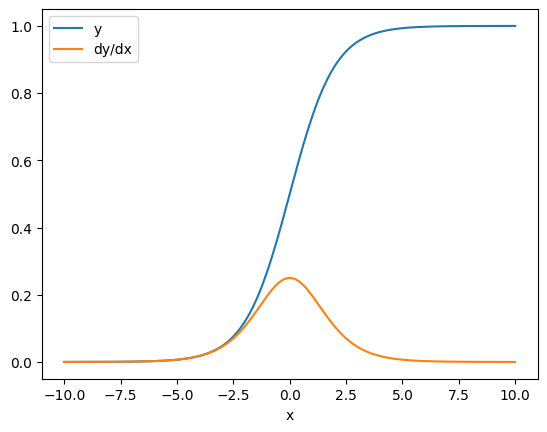

In [ ]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

## Control flow

Because a gradient tape records operations as they are executed, Python control flow is naturally handled (for example, `if` and `while` statements).

Here a different variable is used on each branch of an `if`. The gradient only connects to the variable that was used:

그래디언트 테이프는 실행되는 Ops을 기록하기 때문에 Python 제어 흐름이 자연스럽게 처리됩니다(예: if 및 while 문).

여기서 if의 각 분기마다 다른 변수가 사용됩니다. 그래디언트는 사용된 변수에만 연결됩니다.

In [ ]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2

dv0, dv1 = tape.gradient(result, [v0, v1])

print("dv0=", dv0)
print("dv1=", dv1)

dv0= tf.Tensor(1.0, shape=(), dtype=float32)
dv1= None


Just remember that the control statements themselves are not differentiable, so they are invisible to gradient-based optimizers.

Depending on the value of `x` in the above example, the tape either records `result = v0` or `result = v1**2`. The gradient with respect to `x` is always `None`.

제어문 자체는 미분할 수 없으므로 그래디언트 기반 옵티마이저에서는 볼 수 없습니다.

위의 예에서 x 값에 따라 테이프는 `result = v0` 또는 `result = v1**2`를 기록합니다. x에 대한 기울기는 항상 없음입니다.

In [ ]:
dx = tape.gradient(result, x)

print(dx)

None


## Cases where `gradient` returns `None`

When a target is not connected to a source, `gradient` will return `None`.


target이 소스에 연결되어 있지 않으면 그라디언트는 `None`을 반환합니다.

In [ ]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y

print(tape.gradient(z, x))

None


Here `z` is obviously not connected to `x`, but there are several less-obvious ways that a gradient can be disconnected.

여기서 z는 분명히 x에 연결되어 있지 않지만 그래디언트 연결을 끊을 수 있는 덜 분명한 방법이 몇 가지 있습니다.

### 1. Replaced a variable with a tensor

In the section on ["controlling what the tape watches"](#watches) you saw that the tape will automatically watch a `tf.Variable` but not a `tf.Tensor`.

One common error is to inadvertently replace a `tf.Variable` with a `tf.Tensor`, instead of using `Variable.assign` to update the `tf.Variable`. Here is an example:

"테이프 감시 대상 제어" 섹션에서 테이프가 자동으로 tf.Variable을 감시하지만 tf.Tensor는 감시하지 않는 것을 보았습니다.

일반적인 오류 중 하나는 **Variable.assign을 사용하여 tf.Variable을 업데이트하는 대신 실수로 tf.Variable을 tf.Tensor로 바꾸는 것**입니다. 다음은 예입니다.

In [ ]:
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1
    print(y)

  print(type(x).__name__, ":", tape.gradient(y, x), "\n")

  # print("*" * 60)
  # x = x + 1   # This should be `x.assign_add(1)`
  # print(x)

tf.Tensor(3.0, shape=(), dtype=float32)
ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32) 

tf.Tensor(3.0, shape=(), dtype=float32)
ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32) 



### 2. Did calculations outside of TensorFlow

The tape can't record the gradient path if the calculation exits TensorFlow.
For example:

In [ ]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2
  # print("x2=", x2, "\n")
  # This step is calculated with NumPy
  y = tf.convert_to_tensor(np.mean(x2, axis=0))  # no
  # y = tf.convert_to_tensor(tf.reduce_mean(x2, axis=0)) #yes
  # print("mean of x2=", y, "\n")
  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  y = tf.convert_to_tensor(tf.reduce_mean(y, axis=0))
  # print("y=", y, "\n")

print("tape.gradient(y, x)=", tape.gradient(y, x))

tape.gradient(y, x)= None


### 3. Took gradients through an integer or string

Integers and strings are not differentiable. If a calculation path uses these data types there will be no gradient.

Nobody expects strings to be differentiable, but it's easy to accidentally create an `int` constant or variable if you don't specify the `dtype`.

정수와 문자열은 미분할 수 없습니다. 계산 경로가 이러한 데이터 유형을 사용하는 경우 기울기가 없습니다.

아무도 문자열을 미분할 수 있다고 기대하지 않지만 dtype을 지정하지 않으면 실수로 int 상수나 변수를 생성하기 쉽습니다.

In [ ]:
x = tf.constant(10) # integer type

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


TensorFlow doesn't automatically cast between types, so, in practice, you'll often get a type error instead of a missing gradient.

### 4. Took gradients through a stateful object

State stops gradients. When you read from a stateful object, the tape can only observe the current state, not the history that lead to it.

A `tf.Tensor` is immutable. You can't change a tensor once it's created. It has a _value_, but no _state_. All the operations discussed so far are also stateless: the output of a `tf.matmul` only depends on its inputs.

A `tf.Variable` has internal state—its value. When you use the variable, the state is read. It's normal to calculate a gradient with respect to a variable, but the variable's state blocks gradient calculations from going farther back. For example:


[참고](https://stackoverflow.com/questions/52636943/what-is-a-stateful-object-in-tensorflow)

`State`는 그라디언트를 중지시킵니다. `stateful object`에서 값을 read할 때 테이프는 현재 `state`만 관찰할 수 있으며 현재 `state`로 이어지는 `history`은 관찰할 수 없습니다.

tf.Tensor는 변경할 수 없습니다. 텐서는 생성된 후에는 변경할 수 없습니다. 값은 있지만 state는 없습니다. 지금까지 논의된 모든 ops도 state를 저장하지 않습니다: tf.matmul의 출력은 입력에만 의존합니다.

tf.Variable에는 내부 state, 즉 값이 있습니다. 변수를 사용할 때, `state`를 read 합니다. 변수에 대한 기울기를 계산하는 것은 정상이지만, 변수의 상태는 그래디언트 계산이 더 뒤로 가지 않도록 차단(`x1.assign_add(x0)`)합니다. 예를 들어

In [ ]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.
  # x1 = x1 + x0  # record
  x1.assign_add(x0) # not record
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)

# # This work.
# print(tape.gradient(y, x1))   #dy/dx1 =

None


Similarly, `tf.data.Dataset` iterators and `tf.queue`s are stateful, and will stop all gradients on tensors that pass through them.

## No gradient registered

Some `tf.Operation`s are **registered as being non-differentiable** and will return `None`. Others have **no gradient registered**.

The `tf.raw_ops` page shows which low-level ops have gradients registered.

If you attempt to take a gradient through a float op that has no gradient registered the tape will throw an error instead of silently returning `None`. This way you know something has gone wrong.

For example, the `tf.image.adjust_contrast` function wraps `raw_ops.AdjustContrastv2`, which could have a gradient but the gradient is not implemented:


일부 tf.Operations는 미분할 수 없는 것으로 등록되어 None을 반환합니다. 다른 것들은 등록된 그라디언트가 없습니다.

[tf.raw_ops](https://www.tensorflow.org/api_docs/python/tf/raw_ops) 페이지는 등록된 그라디언트가 있는 low-level ops을 보여줍니다.

등록된 그라디언트가 없는 float 연산을 통해 그라디언트를 사용하려고 하면 테이프에서 자동으로 None을 반환하는 대신 오류가 발생합니다. 이렇게 하면 문제가 발생했음을 알 수 있습니다.

예를 들어, tf.image.adjust_contrast 함수는 그라디언트가 있을 수 있지만 그라디언트가 구현되지 않은 raw_ops.AdjustContrastv2를 래핑합니다.

In [ ]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)

try:
  print(tape.gradient(new_image, [image, delta]))
  assert False   # This should not happen.
except LookupError as e:
  print(f'{type(e).__name__}: {e}')


LookupError: gradient registry has no entry for: AdjustContrastv2


If you need to differentiate through this op, you'll either need to implement the gradient and register it (using `tf.RegisterGradient`) or re-implement the function using other ops.

## Zeros instead of None

In some cases it would be convenient to get 0 instead of `None` for unconnected gradients.  You can decide what to return when you have unconnected gradients using the `unconnected_gradients` argument:

어떤 경우에는 연결되지 않은 그라디언트에 대해 None 대신 0을 얻는 것이 편리합니다. unconnected_gradients 인수를 사용하여 연결되지 않은 그라디언트가 있을 때 반환할 항목을 결정할 수 있습니다.

In [ ]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y**2

print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
